## Introduction
Sendy, in partnership with insight2impact facility, is hosting a Zindi challenge to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling

The main question today is: How can we make machine learning identify patterns and relationships between variables and help the Business(Sendy) make decisions.

Machine learning projects use the CRISP-DM methodology this is a structured approach to planning an ML project with different Tasks namely.

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modelling
5. Deployment
 
A brief explanation on the CRISP-DM is given __[here](https://www.ibm.com/support/knowledgecenter/en/SS3RA7_15.0.0/com.ibm.spss.crispdm.help/crisp_overview.htm)__

### Step 1 : Business Understanding
Here we set the business objective,convert it to a data mining problem and design it to achieve objectives

### Business Problem
How can we make our services reliable,reduce the cost of doing business through improved resource management and planning for order scheduling.

#### Convert it to a data problem
One of the ways sendy can increase realibility of its service is to reduce the time taken to make more deliveries. This brings us to our analysis question.

**Can we predict the estimated time for delivery of orders from the point of driver pickup to the point of arrival at final destination?**

The next phases will involve working with data and will use the following work flow which will feed into the main steps outlined above.

1. Set up Your Work Environment
2. Clean and Transform the data
3. Univariate and Bivariate explolatory analysis
4. Feature engineering
5. Model Building
6. Tune model parameters
7. Evaluate the model using different metrics
8. Model Interpretation and deployment
9. Documentation and presentation of insights



## Step 2: Data Understanding
This involves colleting data,accessing its quality and tranforming variables into their correct formats.

### Step up your work environment
Define dependencies,import necessary libraries and import the required data set

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb

sns.set(style='white', context='notebook', palette='deep')

In [2]:
#Train_Masked has extra columns: Delivery destination (day, month, time)

train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
riders_df = pd.read_csv("data/Riders.csv")

print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head()

(21201, 29) (7068, 25) (960, 5)


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [3]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time
Time from Pickup to Arrival


In [4]:
labels = pd.to_datetime(train_df['Arrival at Destination - Time']) - pd.to_datetime(train_df['Pickup - Time'])
list(labels.dt.seconds[:5]), list(train_df['Time from Pickup to Arrival'][:5])

([745, 1993, 455, 1341, 1214], [745, 1993, 455, 1341, 1214])

In [5]:
train_df = train_df.drop(['Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time'], axis=1)


In [6]:
border = train_df.shape[0]
print(border)

21201


In [7]:
test_df['Time from Pickup to Arrival'] = [np.nan]* test_df.shape[0]
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

train_df.shape, test_df.shape, full_df.shape

((21201, 26), (7068, 26), (28269, 26))

## Data Cleaning and Formatting

In [8]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28269 entries, 0 to 28268
Data columns (total 26 columns):
Order No                                28269 non-null object
User Id                                 28269 non-null object
Vehicle Type                            28269 non-null object
Platform Type                           28269 non-null int64
Personal or Business                    28269 non-null object
Placement - Day of Month                28269 non-null int64
Placement - Weekday (Mo = 1)            28269 non-null int64
Placement - Time                        28269 non-null object
Confirmation - Day of Month             28269 non-null int64
Confirmation - Weekday (Mo = 1)         28269 non-null int64
Confirmation - Time                     28269 non-null object
Arrival at Pickup - Day of Month        28269 non-null int64
Arrival at Pickup - Weekday (Mo = 1)    28269 non-null int64
Arrival at Pickup - Time                28269 non-null object
Pickup - Day of Month         

In [9]:
#Rename the columns,shorten,remove space
new_names = {"Order No": "Order_No", "User Id": "User_Id", "Vehicle Type": "Vehicle_Type",
    "Personal or Business": "Personal_Business", "Placement - Day of Month": "Pla_Mon",
    "Placement - Weekday (Mo = 1)": "Pla_Weekday", "Placement - Time": "Pla_Time", 
    "Confirmation - Day of Month":"Con_Day_Mon", "Confirmation - Weekday (Mo = 1)": "Con_Weekday","Confirmation - Time": "Con_Time", 
    "Arrival at Pickup - Day of Month": "Arr_Pic_Mon", "Arrival at Pickup - Weekday (Mo = 1)": "Arr_Pic_Weekday", 
                "Arrival at Pickup - Time": "Arr_Pic_Time", "Platform Type": "Platform_Type",
     "Pickup - Day of Month": "Pickup_Mon", "Pickup - Weekday (Mo = 1)": "Pickup_Weekday",           
    "Pickup - Time": "Pickup_Time",  "Distance (KM)": "Distance(km)",
    "Precipitation in millimeters": "Precipitation(mm)", "Pickup Lat": "Pickup_Lat", "Pickup Long": "Pickup_Lon", 
    "Destination Lat": "Destination_Lat", "Destination Long":"Destination_Lon", "Rider Id": "Rider_Id",
                            "Time from Pickup to Arrival": "Time_Pic_Arr"
                           }
full_df = full_df.rename(columns=new_names)
full_df.columns


Index(['Order_No', 'User_Id', 'Vehicle_Type', 'Platform_Type',
       'Personal_Business', 'Pla_Mon', 'Pla_Weekday', 'Pla_Time',
       'Con_Day_Mon', 'Con_Weekday', 'Con_Time', 'Arr_Pic_Mon',
       'Arr_Pic_Weekday', 'Arr_Pic_Time', 'Pickup_Mon', 'Pickup_Weekday',
       'Pickup_Time', 'Distance(km)', 'Temperature', 'Precipitation(mm)',
       'Pickup_Lat', 'Pickup_Lon', 'Destination_Lat', 'Destination_Lon',
       'Rider_Id', 'Time_Pic_Arr'],
      dtype='object')

In [10]:
full_df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_Business,Pla_Mon,Pla_Weekday,Pla_Time,Con_Day_Mon,Con_Weekday,...,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:27:30 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,11:44:09 AM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,12:53:03 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,9:43:06 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341.0
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:05:23 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214.0


In [11]:
#convert time from 12h to 24h
def convert_to_24hrs(fulldf):
    for col in fulldf.columns:
        if col.endswith("Time"):
            fulldf[col] = pd.to_datetime(fulldf[col], format='%I:%M:%S %p').dt.strftime("%H:%M:%S")
    return fulldf

full_df = convert_to_24hrs(full_df)

full_df[['Pla_Time', 'Con_Time' , 'Arr_Pic_Time', 'Pickup_Time']][3:6]


,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time
3,09:25:34,09:26:05,09:37:56,09:43:06
4,09:55:18,09:56:18,10:03:53,10:05:23
5,15:07:35,15:08:57,15:21:36,15:30:30


In [12]:
full_df['Temperature'] = full_df['Temperature'].fillna(full_df['Temperature'].median())

In [13]:
full_df['Precipitation(mm)'].fillna(full_df['Precipitation(mm)'].median(), inplace=True)


In [14]:
#Since, we have not been given the actual dates & bikes (same day) were used, is Pick, Arrival date not the same?

month_cols = [col for col in full_df.columns if col.endswith("Mon")]
weekday_cols = [col for col in full_df.columns if col.endswith("Weekday")]

count = 0
instances_of_different_days = [];
for i, row in full_df.iterrows():
    if len(set(row[month_cols].values)) > 1:
        print(count+1, end="\r")
        count = count + 1
        instances_of_different_days.append(list(row[month_cols].values))
instances_of_different_days

[[17, 18, 18, 18], [11, 13, 13, 13]]

In [15]:
#Day & Weekday values are repeated in all rows except 2, we retain only one
#All Vehicle types are Bikes, Vehicle Type is not necessary.

full_df['Day_of_Month'] = full_df[month_cols[0]]
full_df['Day_of_Week'] = full_df[weekday_cols[0]]

full_df.drop(month_cols+weekday_cols, axis=1, inplace=True)
full_df.drop('Vehicle_Type', axis=1, inplace=True)

full_df.head(3)

,Order_No,User_Id,Platform_Type,Personal_Business,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr,Day_of_Month,Day_of_Week
0,Order_No_4211,User_Id_633,3,Business,09:35:46,09:40:10,10:04:47,10:27:30,4,20.4,2.9,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0,9,5
1,Order_No_25375,User_Id_2285,3,Personal,11:16:16,11:23:21,11:40:22,11:44:09,16,26.4,2.9,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0,12,5
2,Order_No_1899,User_Id_265,3,Business,12:39:25,12:42:44,12:49:34,12:53:03,3,23.4,2.9,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0,30,2


## Explolatory Data Analysis

In [16]:
numeric_cols = []
object_cols = []
time_cols = []
for k, v in full_df.dtypes.items():
    if (v != object):
        if (k != "Time_Pic_Arr"):
            numeric_cols.append(k)
    elif k.endswith("Time"):
        time_cols.append(k)
    else:
        object_cols.append(k)
full_df[numeric_cols].head(3) 

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week
0,3,4,20.4,2.9,-1.317755,36.830370,-1.300406,36.829741,9,5
1,3,16,26.4,2.9,-1.351453,36.899315,-1.295004,36.814358,12,5
2,3,3,23.4,2.9,-1.308284,36.843419,-1.300921,36.828195,30,2


In [17]:
full_df[time_cols].head(3)

,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time
0,09:35:46,09:40:10,10:04:47,10:27:30
1,11:16:16,11:23:21,11:40:22,11:44:09
2,12:39:25,12:42:44,12:49:34,12:53:03


In [18]:
full_df[object_cols].head(3)

,Order_No,User_Id,Personal_Business,Rider_Id
0,Order_No_4211,User_Id_633,Business,Rider_Id_432
1,Order_No_25375,User_Id_2285,Personal,Rider_Id_856
2,Order_No_1899,User_Id_265,Business,Rider_Id_155


In [19]:
le = LabelEncoder()
le.fit(full_df['Personal_Business'])
full_df['Personal_Business'] = le.transform(full_df['Personal_Business'])
full_df['Personal_Business'][:2]

0    0
1    1
Name: Personal_Business, dtype: int64

## Exploration of numeric variables

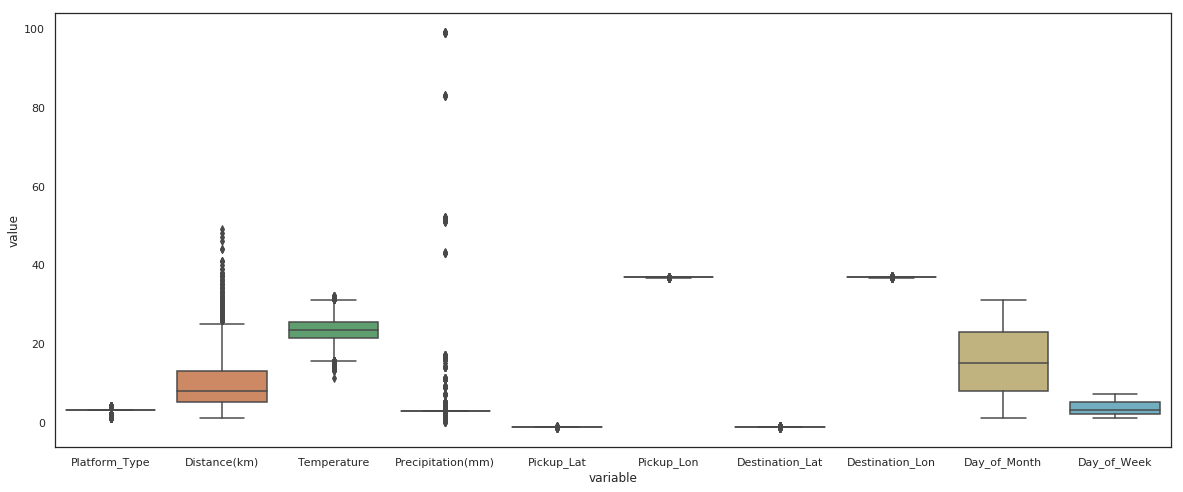

In [20]:
#Outliers Overview for numeric features

plt.figure(figsize=(20, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(full_df[numeric_cols]))
plt.show()

In [21]:
#Correlation between numeric features and the target variable
corr_matrix = full_df[:border][numeric_cols+['Time_Pic_Arr']].corr()
print(corr_matrix["Time_Pic_Arr"].sort_values(ascending=False))

Time_Pic_Arr         1.000000
Distance(km)         0.580608
Destination_Lon      0.070425
Pickup_Lon           0.060285
Day_of_Week          0.009693
Temperature          0.005462
Precipitation(mm)    0.005028
Platform_Type       -0.003827
Day_of_Month        -0.014710
Pickup_Lat          -0.053823
Destination_Lat     -0.061872
Name: Time_Pic_Arr, dtype: float64


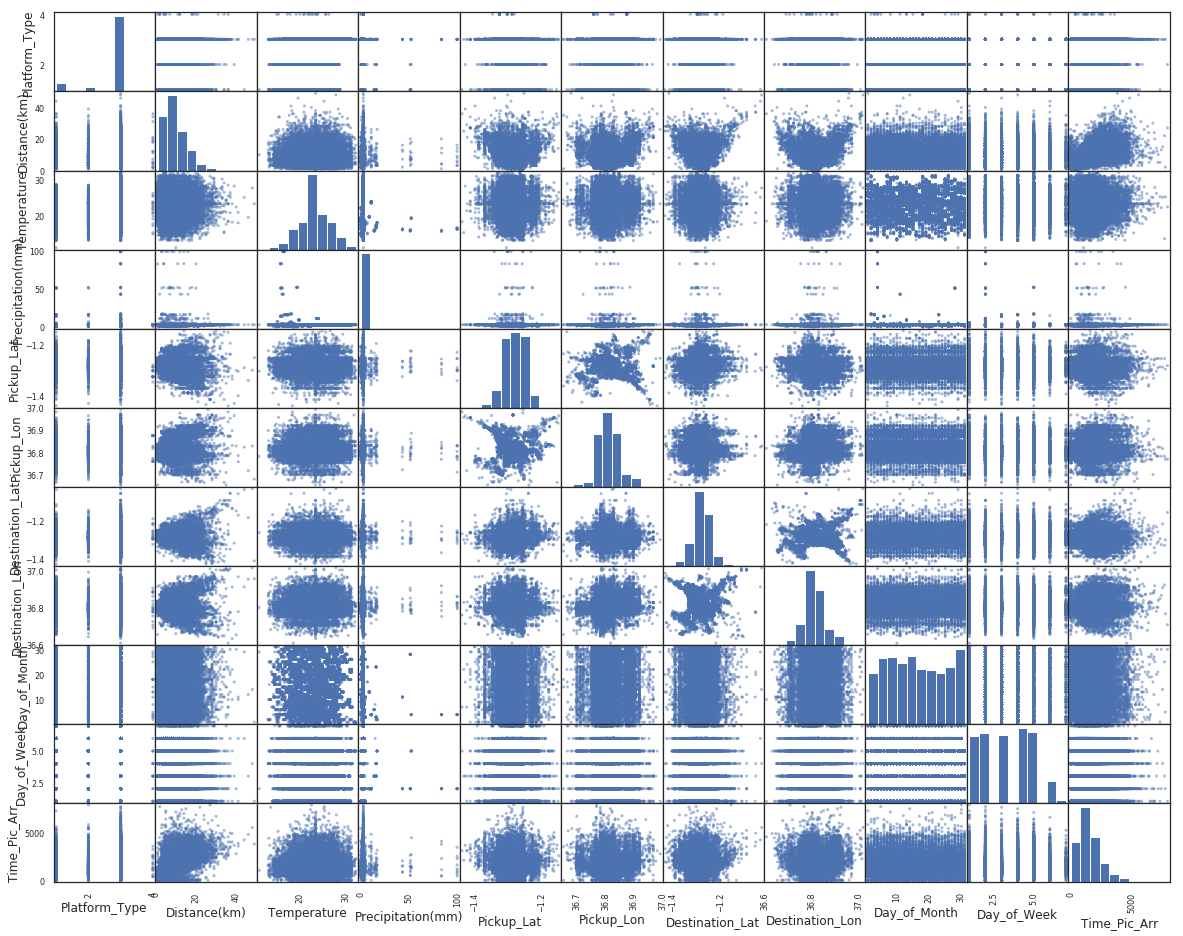

In [22]:
pd.plotting.scatter_matrix(full_df[:border][numeric_cols+['Time_Pic_Arr']], figsize=(20,16))
plt.show()

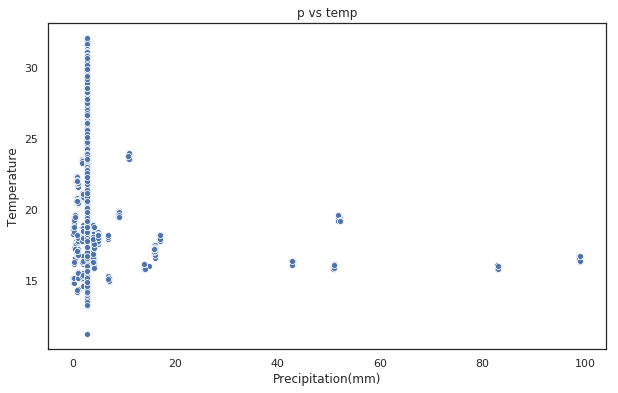

In [24]:
plt.figure(figsize=(10,6))
plt.title('p vs temp')
sns.scatterplot(x=full_df['Precipitation(mm)'],y=full_df['Temperature'])

## Examining the target time(Time from pickup To arrival at the Destination)

In [25]:
#Useful statistics about our target column

full_df[:border]['Time_Pic_Arr'].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time_Pic_Arr, dtype: float64

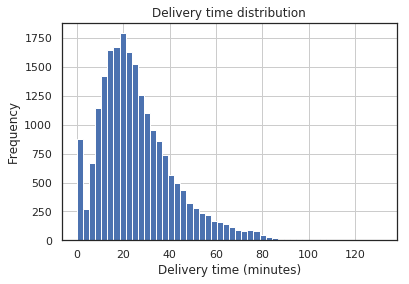

In [26]:
sendy_mins = full_df[:border]['Time_Pic_Arr'] / 60
sendy_mins.hist(bins=50)
plt.title("Delivery time distribution")
plt.xlabel("Delivery time (minutes)")
plt.ylabel("Frequency")
plt.show()

In [27]:
#Delivery times under a minute, is these ok?

under_one = full_df[:border][full_df[:border]['Time_Pic_Arr'] < 60]
times = ['Pla_Time', 'Arr_Pic_Time','Pickup_Time', 'Time_Pic_Arr']
under_one[times].head(3)

,Pla_Time,Arr_Pic_Time,Pickup_Time,Time_Pic_Arr
36,11:47:23,13:02:08,13:35:48,2.0
52,16:16:05,17:10:03,17:14:41,4.0
81,11:44:46,13:32:02,13:51:06,14.0


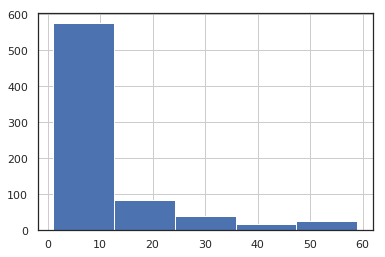

In [28]:
under_one['Time_Pic_Arr'].hist(bins=5)
#most deliveries under a minute are made within 10 seconds, this cant be right
#we can't drop these rows at this stage (these values could be in the test too)

## Modelling(Cross Validation)

In [30]:
features = numeric_cols + ['Personal_Business']

data_df = full_df[features]

y = full_df[:border]['Time_Pic_Arr']
train = data_df[:border]
test = data_df[border:]

test.head()

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week,Personal_Business
21201,3,8,23.4,2.9,-1.333275,36.870815,-1.305249,36.822390,27,3,0
21202,3,5,23.4,2.9,-1.272639,36.794723,-1.277007,36.823907,17,5,0
21203,3,5,22.8,2.9,-1.290894,36.822971,-1.276574,36.851365,27,4,0
21204,3,5,24.5,2.9,-1.290503,36.809646,-1.303382,36.790658,17,1,0
21205,3,6,24.4,2.9,-1.281081,36.814423,-1.266467,36.792161,11,2,0


In [31]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(16960, 11) (4241, 11) (16960,) (4241,)


In [32]:
import lightgbm as lgb 
import xgboost as xgb 

rs = 3
kfold = KFold(n_splits=10, random_state=rs, shuffle=True)

regressors = []
regressors.append(SVR())
regressors.append(GradientBoostingRegressor(random_state=rs))
regressors.append(ExtraTreesRegressor(n_estimators=rs))
regressors.append(RandomForestRegressor(random_state=rs))
regressors.append(xgb.XGBRegressor(random_state=rs, objective="reg:squarederror"))
regressors.append(lgb.LGBMRegressor(random_state=rs))

cv_results = []
for regressor in regressors:     #scores to be minimised are negated (neg)
    cv_results.append(np.sqrt(abs(cross_val_score(regressor, X_train, y=y_train, scoring='neg_mean_squared_error', cv=kfold))))

cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())
    
cv_res = pd.DataFrame({ 
    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "XGBR", "LGBM"],
    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
                       })
cv_res = cv_res.sort_values("CrossValMeans", ascending=True)
print(cv_res)

  Algorithm  CrossValMeans  CrossValErrors
5      LGBM     774.446571       19.534902
4      XGBR     777.332319       18.896201
1       GBR     778.425131       18.939029
3       RFR     838.827114       21.062460
2       EXR     932.626395       22.282398
0       SVR     965.965537       19.006132


## Parameter Tuning

In [33]:
params = {
    'n_estimators':[75], # [75, 95],
    'num_leaves': [15], #[12,15, 17],
    'reg_alpha': [0.02], #[0.02, 0.05],
    'min_data_in_leaf': [300],  #[250, 280, 300]
    'learning_rate': [0.1], #[0.05, 0.1, 0.25],
    'objective': ['regression'] #['regression', None]
    }

lsearch = GridSearchCV(estimator = lgb.LGBMRegressor(random_state=rs), cv=kfold,scoring='neg_mean_squared_error', param_grid=params)
lgbm = lsearch.fit(X_train, y_train)

l_params = lgbm.best_params_
l_score = np.sqrt(abs(lgbm.best_score_))
print(lgbm.best_params_, np.sqrt(abs(lgbm.best_score_)))

#try: RandomSearch, hyperopt (bayesian)

{'learning_rate': 0.1, 'min_data_in_leaf': 300, 'n_estimators': 75, 'num_leaves': 15, 'objective': 'regression', 'reg_alpha': 0.02} 773.7938072953625


In [34]:
RFC = RandomForestRegressor(random_state=rs)
rf_param = {"max_depth":[None], "max_features":[3], "min_samples_split":[10],
           "min_samples_leaf": [3], "n_estimators":[300]}
rsearch = GridSearchCV(RFC, cv=kfold, scoring='neg_mean_squared_error',param_grid=rf_param)
rfm = rsearch.fit(X_train, y_train)

r_score = np.sqrt(abs(rfm.best_score_))
r_params = rfm.best_params_
print(r_score, r_params)

775.2922347118081 {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}


### Evaluating models

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, n_jobs=-1, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generating a plot of test and training learning curve"""
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Trainig examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error', shuffle=True)
    
    #scores - 5 runs, each with 10 fold
    train_scores_mean = -np.mean(train_scores, axis=1) #5 means (each size)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r' )
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt


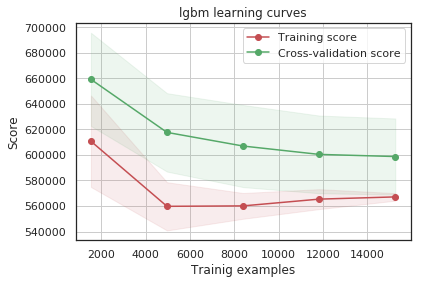

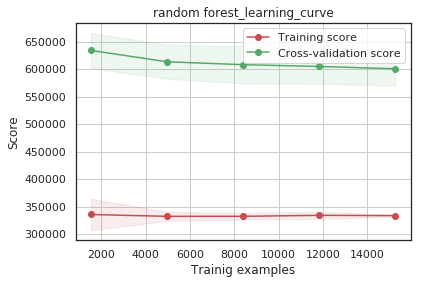

In [36]:
#Learning Curves

g = plot_learning_curve(lgbm.best_estimator_, "lgbm learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(rfm.best_estimator_, "random forest_learning_curve", X_train, y_train, cv=kfold)

#lgbm: mse error decreases drastically then levels at the train size of 12000 rows adding more data 
#will not improve the score significantly, in this case we try a diff approach (changing the data)
#rf: mse error decreases very slowly, this model would require a lot of data to improve score

## Feature importance

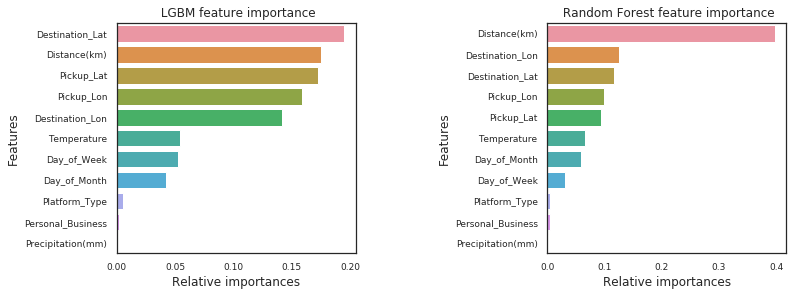

In [37]:
vals = lgbm.best_estimator_.feature_importances_
l_importance = np.array([ val/sum(vals) for val in vals ])
r_importance  = rfm.best_estimator_.feature_importances_
feats = np.array(features)

fig,axes = plt.subplots(1,2, figsize=(12, 8))
plt.subplots_adjust(top=0.6, bottom=0.2, hspace=.6, wspace=0.8)

indices = np.argsort(l_importance)[::-1]
g = sns.barplot(y=feats[indices], x=l_importance[indices], orient='h', ax=axes[0])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" LGBM feature importance")

index = np.argsort(r_importance)[::-1]
g = sns.barplot(y=feats[index], x=r_importance[index], orient='h', ax=axes[1])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" Random Forest feature importance")
plt.show()

### Training the Model and making a prediction

In [40]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lparams = {
           'learning_rate': 0.1, 'min_data_in_leaf': 300, 
           'n_estimators': 75, 'num_leaves': 20, 'random_state':rs,
           'objective': 'regression', 'reg_alpha': 0.02,
          'feature_fraction': 0.9, 'bagging_fraction':0.9}


lgbm = lgb.train(lparams, lgb_train, valid_sets=lgb_eval, num_boost_round=20, early_stopping_rounds=20)

lpred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

print("The RMSE of prediction is ", mean_squared_error(y_test, lpred)**0.5)


[1]	valid_0's l2: 925091
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 872052
[3]	valid_0's l2: 841286
[4]	valid_0's l2: 803873
[5]	valid_0's l2: 782547
[6]	valid_0's l2: 755759
[7]	valid_0's l2: 733910
[8]	valid_0's l2: 715880
[9]	valid_0's l2: 701211
[10]	valid_0's l2: 688493
[11]	valid_0's l2: 678399
[12]	valid_0's l2: 670359
[13]	valid_0's l2: 663349
[14]	valid_0's l2: 658802
[15]	valid_0's l2: 653624
[16]	valid_0's l2: 649161
[17]	valid_0's l2: 645516
[18]	valid_0's l2: 642462
[19]	valid_0's l2: 639780
[20]	valid_0's l2: 637244
[21]	valid_0's l2: 634821
[22]	valid_0's l2: 632842
[23]	valid_0's l2: 631024
[24]	valid_0's l2: 628628
[25]	valid_0's l2: 626985
[26]	valid_0's l2: 625900
[27]	valid_0's l2: 624468
[28]	valid_0's l2: 623245
[29]	valid_0's l2: 622862
[30]	valid_0's l2: 621969
[31]	valid_0's l2: 621360
[32]	valid_0's l2: 620785
[33]	valid_0's l2: 620470
[34]	valid_0's l2: 619917
[35]	valid_0's l2: 619323
[36]	valid_0's l2: 618585
[37]	valid_0